**Урок 9. Python применение продвинутых методов**

Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

In [12]:
!pip install bootstrapped

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from statsmodels.stats.power import TTestIndPower

import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats


In [19]:
df = pd.read_excel('./sample_data/результаты А_B.xlsx')

In [ ]:
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [5]:
# Количество уникальных пользователей
df["userid"].nunique()

90189

Количество пользователей в каждой группе

In [6]:
df_vc = df['version'].value_counts()

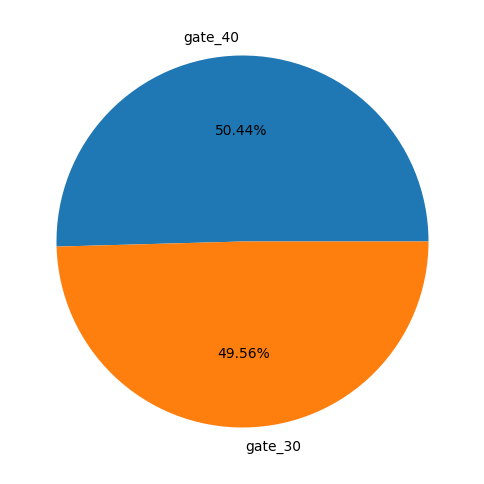

In [7]:
plt.figure(figsize=(6,8))
plt.pie(x= df_vc.values , labels= df_vc.index ,autopct='%.2f%%' )
plt.show()

**Размер выборки больше 5000 - применяем тест Колмогорова-Смирнова для  проверки на нормальность.**

In [8]:
# Проверим принадлежность выборок к нормальному распределению.
print(st.kstest(df['retention_1'], 'norm'))
print(st.kstest(df['retention_7'], 'norm'))

KstestResult(statistic=0.5, pvalue=0.0, statistic_location=0, statistic_sign=-1)
KstestResult(statistic=0.5, pvalue=0.0, statistic_location=0, statistic_sign=-1)


p-value < alpha: анализируемое распределение  отличается от нормального.

In [25]:
control = df[df['version'] == 'gate_30']
test = df[df['version'] == 'gate_40']

**Bootstrap**

In [26]:
s_1 = control.retention_1.values

s_2 = test.retention_1.values

b_1 = bs.bootstrap_ab(s_1, s_2, stat_func=bs_stats.mean,
                    compare_func=bs_compare.difference, alpha=0.05, num_iterations=10_000)

print(b_1.lower_bound, b_1.upper_bound)

-0.00044654025067791814 0.012363566175228423


0 входит - на уровне retention_1 значимых различий нет.

In [27]:
s_1 = control.retention_7.values

s_2 = test.retention_7.values

b_7 = bs.bootstrap_ab(s_1, s_2, stat_func=bs_stats.mean,
                    compare_func=bs_compare.difference, alpha=0.05, num_iterations=10_000)

print(b_7.lower_bound, b_7.upper_bound)

0.00304253653918243 0.013138781320537526


0 не входит  - на уровне retention_7 есть статичически значимые различия в пользу gate_30.

**Расчет мощности**

In [35]:
C_mean = control.retention_1.values.mean()

T_mean = test.retention_1.values.mean()


C_std = control.retention_1.values.std()

T_std = test.retention_1.values.std()

In [36]:
print(len(control.retention_1.values), len(test.retention_1.values))

44700 45489


In [37]:
n =  len(control.retention_1.values)

In [38]:
S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [39]:
ef =float((T_mean-C_mean)/ S)

In [40]:
alpha = 0.05
analysis = TTestIndPower()
result = analysis.solve_power(ef, power=None,
nobs1=n, ratio=1.0, alpha=alpha)
print("Мощность теста: ", result)

Мощность теста:  0.4272457487546161


In [ ]:
# Количество в процентоном отношении retention_1 и retention_7
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"1-day retention количество пользователей: {round(df_retention[0],2)}% \
      \n7-days retention количество пользователей: {round(df_retention[1],2)}%")

1-day retention количество пользователей: 44.52%       
7-days retention количество пользователей: 18.61%


In [ ]:
# Расчет 1-дневного и 7-дневного удержания для каждой группы A/B теста.
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


In [ ]:
control = df[df['version'] == 'gate_30'].copy()

control.retention_1 = control.retention_1.replace({True: 1, False: 0})
control.retention_7 = control.retention_7.replace({True: 1, False: 0})

In [ ]:
experimental = df[df['version'] == 'gate_40'].copy()

experimental.retention_1 = experimental.retention_1.replace({True: 1, False: 0})
experimental.retention_7 = experimental.retention_7.replace({True: 1, False: 0})

In [ ]:
def AB_testing(x1 , x2 ):
    x_bar1 = np.mean(x1)
    var1 = np.var(x1)
    n1 = len(x1)

    x_bar2 = np.mean(x2)
    var2 = np.var(x2)
    n2 = len(x2)

    z_score = (x_bar1 - x_bar2) / np.sqrt((var1 / n1) + (var2 / n2))
    p_value = st.norm.cdf(z_score)
    if z_score > 0:
        p_value = 2*(1 - p_value)
    else:
        p_value = 2 * p_value
    return print(f'z-score : {z_score} , p-value : {p_value}')

In [ ]:
AB_testing(control['retention_7'] , experimental['retention_7'])

z-score : 3.164064040149098 , p-value : 0.001555825573707148


Поскольку p-value меньше alpha = 0.05 можно утверждать, вариант с gate_40 не имеет статистически значимую разницу с gate_30 на уровне 7 days retention.

In [ ]:
AB_testing(control['retention_1'] , experimental['retention_1'])

z-score : 1.7840972718297632 , p-value : 0.0744078605234999


На уровне 1 days retention p-value практически равен alpha = 0.05 - можно предположить, что данные в обеих группах практически равны и разницы нет.

##Рекомендации:
Наблюдается  небольшое снижение 1 days retention , когда ворота были
перемещены на уровень 40 (44,2%), по сравнению с контрольной группой, когда они находились на уровне 30 (44,8%).

Процент вернувшихся игроков контрольной группы через 7 дней составляет 19,0%, тогда как процент вернувшихся игроков экспериментальной группы составляет 18,2%.

Эксперимент показывает, что перемещение ворот на 40-й уровень отрицательно влияет на количество вернувшихся игроков через 7 дней.

Рекомендуется оставить ворота на уровне 30.